Modelo 3 - Red Neuronal (Deep Learning)

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.16.1
GPU disponible: []


In [11]:
# Cargar datos guardados del notebook 03
data_path = r"C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\data\processed\preprocessed_data.pkl"

with open(data_path, 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X_train']
X_val = data_dict['X_val']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_val = data_dict['y_val']
y_test = data_dict['y_test']

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribución target (train): {np.bincount(y_train)}")

Train set: (61059, 26)
Validation set: (20353, 26)
Test set: (20354, 26)

Distribución target (train): [54244  6815]


Construir Red Neuronal

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Calcular pesos de clase para manejar desbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class weights:")
print(f"  Clase 0 (No readmit): {class_weight_dict[0]:.4f}")
print(f"  Clase 1 (Readmit <30d): {class_weight_dict[1]:.4f}")

Class weights:
  Clase 0 (No readmit): 0.5628
  Clase 1 (Readmit <30d): 4.4798


In [13]:
# Arquitectura de la red neuronal
def create_neural_network(input_dim):
    model = Sequential([
        # Capa de entrada
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.3),
        
        # Capas ocultas
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(16, activation='relu'),
        Dropout(0.2),
        
        # Capa de salida
        Dense(1, activation='sigmoid')
    ])
    
    return model

# Crear modelo
input_dim = X_train.shape[1]
nn_model = create_neural_network(input_dim)

# Compilar modelo
nn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auc'), keras.metrics.Precision(), keras.metrics.Recall()]
)

# Ver arquitectura
print("\nARQUITECTURA DE LA RED NEURONAL:")
print("="*60)
nn_model.summary()

C:\Users\davfl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



ARQUITECTURA DE LA RED NEURONAL:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,233 (59.50 KB)

 Trainable params: 14,785 (57.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    r"C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5",
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

print("Callbacks configurados:")
print("  - Early Stopping (patience=10)")
print("  - ReduceLROnPlateau (patience=5)")
print("  - ModelCheckpoint (guarda mejor modelo)")

Callbacks configurados:
  - Early Stopping (patience=10)
  - ReduceLROnPlateau (patience=5)
  - ModelCheckpoint (guarda mejor modelo)


Entrenar Red Neuronal

In [15]:
import time

print("Iniciando entrenamiento de la Red Neuronal...")
print("="*60)

start_time = time.time()

# Entrenar modelo
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    class_weight=class_weight_dict,
    callbacks=callbacks_list,
    verbose=1
)

training_time_nn = time.time() - start_time

print("\n" + "="*60)
print(f"Entrenamiento completado en {training_time_nn:.2f} segundos")
print(f"Épocas entrenadas: {len(history.history['loss'])}")

Iniciando entrenamiento de la Red Neuronal...
Epoch 1/100
231/239 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5793 - auc: 0.5435 - loss: 0.7458 - precision: 0.1281 - recall: 0.4650
Epoch 1: val_auc improved from None to 0.62582, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5560 - auc: 0.5555 - loss: 0.7151 - precision: 0.1286 - recall: 0.5155 - val_accuracy: 0.4727 - val_auc: 0.6258 - val_loss: 0.7008 - val_precision: 0.1400 - val_recall: 0.7248 - learning_rate: 0.0010
Epoch 2/100
229/239 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5532 - auc: 0.5945 - loss: 0.6824 - precision: 0.1390 - recall: 0.5747
Epoch 2: val_auc improved from 0.62582 to 0.63583, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5574 - auc: 0.6000 - loss: 0.6791 - precision: 0.1404 - recall: 0.5786 - val_accuracy: 0.5473 - val_auc: 0.6358 - val_loss: 0.6736 - val_precision: 0.1497 - val_recall: 0.6535 - learning_rate: 0.0010
Epoch 3/100
236/239 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5581 - auc: 0.6117 - loss: 0.6739 - precision: 0.1443 - recall: 0.6003
Epoch 3: val_auc improved from 0.63583 to 0.63879, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5616 - auc: 0.6111 - loss: 0.6745 - precision: 0.1451 - recall: 0.5984 - val_accuracy: 0.5640 - val_auc: 0.6388 - val_loss: 0.6790 - val_precision: 0.1525 - val_recall: 0.6380 - learning_rate: 0.0010
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5830 - auc: 0.6263 - loss: 0.6651 - precision: 0.1523 - recall: 0.6101
Epoch 4: val_auc improved from 0.63879 to 0.64200, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5822 - auc: 0.6264 - loss: 0.6686 - precision: 0.1529 - recall: 0.6041 - val_accuracy: 0.5718 - val_auc: 0.6420 - val_loss: 0.6633 - val_precision: 0.1553 - val_recall: 0.6394 - learning_rate: 0.0010
Epoch 5/100
226/239 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5784 - auc: 0.6279 - loss: 0.6669 - precision: 0.1510 - recall: 0.6039
Epoch 5: val_auc improved from 0.64200 to 0.64364, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5760 - auc: 0.6305 - loss: 0.6667 - precision: 0.1519 - recall: 0.6106 - val_accuracy: 0.5880 - val_auc: 0.6436 - val_loss: 0.6630 - val_precision: 0.1594 - val_recall: 0.6301 - learning_rate: 0.0010
Epoch 6/100
238/239 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5996 - auc: 0.6411 - loss: 0.6596 - precision: 0.1580 - recall: 0.6048
Epoch 6: val_auc improved from 0.64364 to 0.64590, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5979 - auc: 0.6400 - loss: 0.6627 - precision: 0.1589 - recall: 0.6063 - val_accuracy: 0.5954 - val_auc: 0.6459 - val_loss: 0.6589 - val_precision: 0.1602 - val_recall: 0.6191 - learning_rate: 0.0010
Epoch 7/100
233/239 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5888 - auc: 0.6401 - loss: 0.6642 - precision: 0.1573 - recall: 0.6086
Epoch 7: val_auc improved from 0.64590 to 0.64707, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5966 - auc: 0.6412 - loss: 0.6615 - precision: 0.1585 - recall: 0.6067 - val_accuracy: 0.5945 - val_auc: 0.6471 - val_loss: 0.6603 - val_precision: 0.1608 - val_recall: 0.6244 - learning_rate: 0.0010
Epoch 8/100
230/239 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5963 - auc: 0.6365 - loss: 0.6642 - precision: 0.1578 - recall: 0.6039
Epoch 8: val_auc improved from 0.64707 to 0.64753, saving model to C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5


239/239 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6019 - auc: 0.6391 - loss: 0.6631 - precision: 0.1591 - recall: 0.5991 - val_accuracy: 0.6022 - val_auc: 0.6475 - val_loss: 0.6590 - val_precision: 0.1618 - val_recall: 0.6138 - learning_rate: 0.0010
Epoch 9/100
232/239 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6032 - auc: 0.6434 - loss: 0.6611 - precision: 0.1611 - recall: 0.6054
Epoch 9: val_auc did not improve from 0.64753
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6028 - auc: 0.6432 - loss: 0.6604 - precision: 0.1611 - recall: 0.6082 - val_accuracy: 0.6062 - val_auc: 0.6457 - val_loss: 0.6564 - val_precision: 0.1618 - val_recall: 0.6050 - learning_rate: 0.0010
Epoch 10/100
234/239 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5977 - auc: 0.6469 - loss: 0.6583 - precision: 0.1595 - recall: 0.6129
Epoch 10: val_auc did not improve from 0.64753
239/239 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5974 - auc: 0.6464 - loss: 0.6588 - precision: 0.1599 - recall: 0

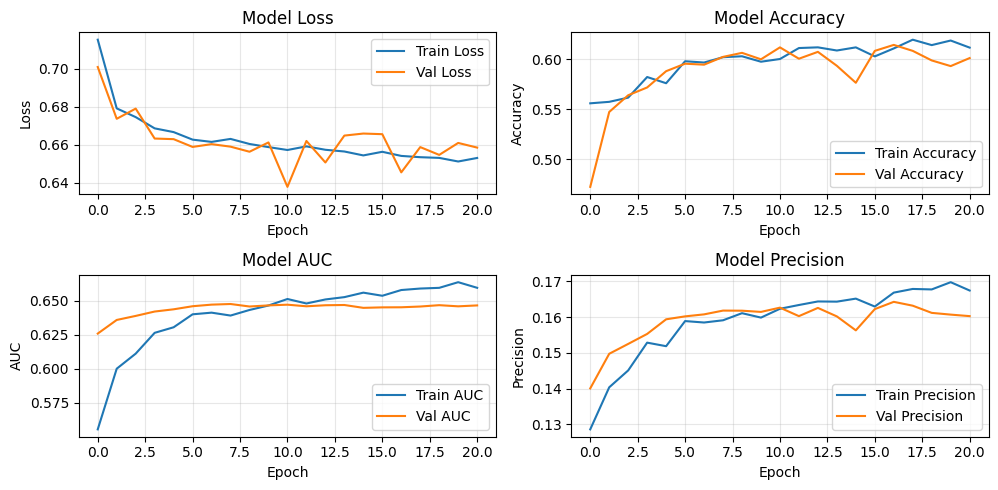

Curvas de aprendizaje generadas


In [17]:
# Graficar curvas de entrenamiento
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
axes[1, 0].set_title('Model AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision
axes[1, 1].plot(history.history['precision'], label='Train Precision')
axes[1, 1].plot(history.history['val_precision'], label='Val Precision')
axes[1, 1].set_title('Model Precision')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Curvas de aprendizaje generadas")

Evaluar Red Neuronal

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Predicciones
print("Generando predicciones...")
y_train_pred_nn_proba = nn_model.predict(X_train, verbose=0).flatten()
y_val_pred_nn_proba = nn_model.predict(X_val, verbose=0).flatten()
y_test_pred_nn_proba = nn_model.predict(X_test, verbose=0).flatten()

# Convertir probabilidades a clases (threshold=0.5)
y_train_pred_nn = (y_train_pred_nn_proba > 0.5).astype(int)
y_val_pred_nn = (y_val_pred_nn_proba > 0.5).astype(int)
y_test_pred_nn = (y_test_pred_nn_proba > 0.5).astype(int)

print("\nEVALUACIÓN RED NEURONAL")
print("="*60)

# Métricas en Train
print("\nTRAIN SET:")
print(f"Accuracy:  {accuracy_score(y_train, y_train_pred_nn):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred_nn):.4f}")
print(f"Recall:    {recall_score(y_train, y_train_pred_nn):.4f}")
print(f"F1-Score:  {f1_score(y_train, y_train_pred_nn):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_pred_nn_proba):.4f}")

# Métricas en Validation
print("\nVALIDATION SET:")
print(f"Accuracy:  {accuracy_score(y_val, y_val_pred_nn):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_nn):.4f}")
print(f"Recall:    {recall_score(y_val, y_val_pred_nn):.4f}")
print(f"F1-Score:  {f1_score(y_val, y_val_pred_nn):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_val, y_val_pred_nn_proba):.4f}")

# Métricas en Test
print("\nTEST SET:")
print(f"Accuracy:  {accuracy_score(y_test, y_test_pred_nn):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_nn):.4f}")
print(f"Recall:    {recall_score(y_test, y_test_pred_nn):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_test_pred_nn):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_pred_nn_proba):.4f}")

# Matriz de confusión
print("\n" + "="*60)
print("MATRIZ DE CONFUSIÓN (Test Set):")
print(confusion_matrix(y_test, y_test_pred_nn))

print("\n" + "="*60)
print("CLASSIFICATION REPORT (Test Set):")
print(classification_report(y_test, y_test_pred_nn, target_names=['No Readmit', 'Readmit <30d']))

Generando predicciones...

EVALUACIÓN RED NEURONAL

TRAIN SET:
Accuracy:  0.6156
Precision: 0.1690
Recall:    0.6241
F1-Score:  0.2660
ROC-AUC:   0.6658

VALIDATION SET:
Accuracy:  0.6117
Precision: 0.1627
Recall:    0.5980
F1-Score:  0.2558
ROC-AUC:   0.6468

TEST SET:
Accuracy:  0.6133
Precision: 0.1649
Recall:    0.6068
F1-Score:  0.2593
ROC-AUC:   0.6536

MATRIZ DE CONFUSIÓN (Test Set):
[[11105  6978]
 [  893  1378]]

CLASSIFICATION REPORT (Test Set):
              precision    recall  f1-score   support

  No Readmit       0.93      0.61      0.74     18083
Readmit <30d       0.16      0.61      0.26      2271

    accuracy                           0.61     20354
   macro avg       0.55      0.61      0.50     20354
weighted avg       0.84      0.61      0.68     20354



In [21]:
# Cargar predicciones de modelos tradicionales
predictions_path = r"C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\traditional_models_predictions.pkl"

with open(predictions_path, 'rb') as f:
    pred_dict = pickle.load(f)

y_test_pred_rf = pred_dict['y_test_pred_rf']
y_test_pred_gb = pred_dict['y_test_pred_gb']
y_test_proba_rf = pred_dict['y_test_proba_rf']
y_test_proba_gb = pred_dict['y_test_proba_gb']
training_time_rf = pred_dict['training_time_rf']
training_time_gb = pred_dict['training_time_gb']

# Crear tabla comparativa con valores exactos
comparison_data = {
    'Model': ['Random Forest', 'Gradient Boosting', 'Neural Network'],
    'Training Time (s)': [training_time_rf, training_time_gb, training_time_nn],
    'Test Accuracy': [
        accuracy_score(y_test, y_test_pred_rf),
        accuracy_score(y_test, y_test_pred_gb),
        accuracy_score(y_test, y_test_pred_nn)
    ],
    'Test Precision': [
        precision_score(y_test, y_test_pred_rf),
        precision_score(y_test, y_test_pred_gb),
        precision_score(y_test, y_test_pred_nn)
    ],
    'Test Recall': [
        recall_score(y_test, y_test_pred_rf),
        recall_score(y_test, y_test_pred_gb),
        recall_score(y_test, y_test_pred_nn)
    ],
    'Test F1-Score': [
        f1_score(y_test, y_test_pred_rf),
        f1_score(y_test, y_test_pred_gb),
        f1_score(y_test, y_test_pred_nn)
    ],
    'Test ROC-AUC': [
        roc_auc_score(y_test, y_test_proba_rf),
        roc_auc_score(y_test, y_test_proba_gb),
        roc_auc_score(y_test, y_test_pred_nn_proba)
    ]
}

df_comparison = pd.DataFrame(comparison_data)

print("\nCOMPARACIÓN FINAL DE MODELOS")
print("="*80)
print(df_comparison.to_string(index=False))

# Identificar mejor modelo por ROC-AUC
best_auc_idx = df_comparison['Test ROC-AUC'].idxmax()
best_auc_name = df_comparison.loc[best_auc_idx, 'Model']

# Identificar mejor modelo por F1-Score (más balanceado)
best_f1_idx = df_comparison['Test F1-Score'].idxmax()
best_f1_name = df_comparison.loc[best_f1_idx, 'Model']

print("\n" + "="*80)
print(f"MEJOR MODELO (por ROC-AUC): {best_auc_name}")
print(f"  ROC-AUC: {df_comparison.loc[best_auc_idx, 'Test ROC-AUC']:.4f}")

print(f"\nMEJOR MODELO (por F1-Score): {best_f1_name}")
print(f"  F1-Score: {df_comparison.loc[best_f1_idx, 'Test F1-Score']:.4f}")
print(f"  Recall: {df_comparison.loc[best_f1_idx, 'Test Recall']:.4f}")


COMPARACIÓN FINAL DE MODELOS
            Model  Training Time (s)  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Test ROC-AUC
    Random Forest           1.531347       0.824899        0.236874     0.256275       0.246193      0.669586
Gradient Boosting          13.372482       0.887983        0.444444     0.015852       0.030612      0.684172
   Neural Network          36.163110       0.613295        0.164911     0.606781       0.259339      0.653574

MEJOR MODELO (por ROC-AUC): Gradient Boosting
  ROC-AUC: 0.6842

MEJOR MODELO (por F1-Score): Neural Network
  F1-Score: 0.2593
  Recall: 0.6068


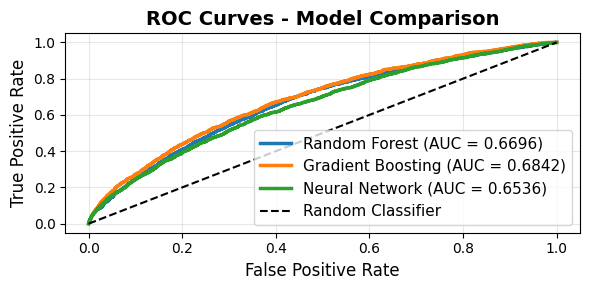

In [23]:
from sklearn.metrics import roc_curve

# Calcular curvas ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_proba_gb)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_test_pred_nn_proba)

# Graficar
plt.figure(figsize=(6, 3))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_test_proba_rf):.4f})', linewidth=2.5)
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_score(y_test, y_test_proba_gb):.4f})', linewidth=2.5)
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {roc_auc_score(y_test, y_test_pred_nn_proba):.4f})', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
import os

# Verificar que los modelos existen
nn_path = r"C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5"

if os.path.exists(nn_path):
    print(f"Neural Network guardado correctamente en:")
    print(f"  {nn_path}")
    print(f"  Tamaño: {os.path.getsize(nn_path) / 1024:.2f} KB")
else:
    print("Warning: Neural Network no se guardó correctamente")

print("\nRECUERDA: Guarda los modelos Random Forest y Gradient Boosting en el notebook 03")

Neural Network guardado correctamente en:
  C:\Users\davfl\OneDrive\Desktop\Maestria en Analitica de Datos\Big Data\healthcare-readmission-project\models\neural_network_best.h5
  Tamaño: 250.36 KB

RECUERDA: Guarda los modelos Random Forest y Gradient Boosting en el notebook 03
